# Rozpoznawanie obrazów i testy ataków adwersarialnych<br>(ang. *Image Classification and Adversarial Attack Testing*)

> Rozpoznawanie obrazów z wykorzystaniem bazy danych **CIFAR-10**/**CIFAR-100** oraz próba przeprowadzenia ataków adwersarialnych na wytrenowany model.

---

##Uwaga ❕  
Poniższy projekt był realizowany przy użyciu środowiska **Google Colaboratory**.  
Zalecane jest używanie tego środowiska w celu poprawnej instalacji i poprawnego użycia pakietów.

##Uwaga 2 ❕
Etapy:
- **Tworzenie modelu**
- **Kompilacja modelu**
- **Trenowanie modelu**
Można pominąć gdy wczytujemy model z pliku zewnętrznego

In [ ]:
!pip install cleverhans

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras import models, layers

In [ ]:
import numpy as np

# Tworzenie modelu


## **Warstwa wejściowa**


Liczba filtrów (detektorów cech) - 32 różne wzorce

32 - liczba neuronów
```
filters = 32
```

Rozmiar filtra (3x3 piksele) - każdy filtr przesuwa się po obrazie jako kwadrat 3x3 px (operacja splotu)
```
kernel_size = (3, 3)
```
Funkcja aktywacji ReLU

***f(x) = max(0, x)***

```
activation = 'relu'
```
Rozmiar wejścia - obrazu (32x32 px, 3 kanały RGB).  
Ponieważ zbiór CIFAR-10 zawiera obrazy o wymiarach 32x32 px.
```
input_shape = (32, 32, 3)
```


In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(
    filters = 32,              # Liczba filtrów (detektorów cech) - 32 różne wzorce
    kernel_size = (3, 3),      # Rozmiar filtra (3x3 piksele)
    activation = 'relu',       # Funkcja aktywacji ReLU
    input_shape = (32, 32, 3), # Rozmiar obrazu (32x32, 3 kanały RGB)
    padding = 'same'           # Dodaje odpowiednie zera do brzegów obrazu, aby zachować jego wymiary po konwolucji
))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Warstwa MaxPooling**

> **Warstwa zmniejsza rozmiar danych. Redukuje rozdzielczość obrazu, przyspiesza obliczenia i ogranicza ryzyko przeuczenia.**

Dzieli obraz na bloki 2x2 i wybiera największą wartość z każdego bloku.

W uproszczeniu dzieli aktualny rozmiar obrazu przez 2. Np 32x32 -> MaxPooling -> 16x16 itd
```
pool_size = (2,2)
```


In [ ]:
model.add(layers.MaxPooling2D(pool_size = (2,2)))

## **Warstwy konwolucyjne**

> Dodanie kolejnych warstw w celu rozpoznawania bardziej złożonych wzorców

Funkcja odpowiedzialna za dodawanie warstw konwolucyjnych, jako parametr przyjmuje `conv_layer` w postaci tablicy:

Przykład: ( [64, 64] ) - dwie warstwy konwolucyjne po 64 filtry

Oraz parametr `input_shape`, który jest reprezentacją wymiaru danych wejściowych (np 32x32 pixele = (32, 32))
```
def add_conv_layers(conv_layer, input_shape)
```

In [ ]:
def add_conv_layers(conv_layers, input_shape):
    for conv_layer in conv_layers:
        model.add(layers.Conv2D(conv_layer, (3, 3), activation = 'relu', padding='same'))

        if input_shape > (4, 4):
            model.add(layers.MaxPooling2D((2,2)))
            input_shape = tuple(int(x / 2) for x in input_shape)

Wywołanie funkcji (stworzenie warstw)

`model.input_shape[1:3]` - ponieważ chcemy wyciągnąć tylko rozmiar obrazu który wrzucamy w sieć neuronową

In [ ]:
inp_sh = tuple(int(x / 2) for x in model.input_shape[1:3]) # wzięcie rozmiaru wejścia, podzielone na 2 ponieważ była już jedna warstwa poolingowa
print(inp_sh)

(16, 16)


In [ ]:
add_conv_layers([64, 128, 256, 256], inp_sh)

## **Warstwa spłaszczająca**

> Stosowana ponieważ po warstwach konwolucyjnych dane mają kształt trójwymiarowy (wysokość x szerokość x kanały). Musimy je zmienić na wektor w celu klasyfikacji.

Zmiana danych np. (7, 7, 64) na wektor 7 x 7 x 64 = 3136

Pierwotne podejście:  
`model.add(layers.Flatten())`

Nowe podejście:   
`model.add(layers.GlobalAveragePooling2D())`

In [ ]:
model.add(layers.GlobalAveragePooling2D())

## **Warstwa w pełni połączona (Dense)**

> Warstwa gęsta - klasyczna warstwa neuronowa

128 - liczba neuronów w warstwie gęstej

In [ ]:
model.add(layers.Dense(128, activation = 'relu'))

## **Warstwa wyjściowa**

> Ostatnia warstwa, odpowiedzialna za przewidywanie klas.

`model.add(layers.Dense(10, activation = 'softmax'))`

10 - liczba neuronów

<br>

###❔ **Dlaczego 10**

Dla zbioru CIFAR-10 jest 10 klas

1: samolot, 2: samochód, ..., 10: statek

<br>
❕ W przyszłości liczbę można zastąpić zmienną *num_classes*

In [ ]:
model.add(layers.Dense(10, activation = 'softmax'))

## Ostateczny wygląd modelu

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,012,682 (3.86 MB)

 Trainable params: 1,012,682 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

# Kompilacja modelu

Decyduje w jaki sposób model aktualizuje swoje wagi podczas uczenia

- *Adaptive Moment Estimation* - efektywny optymalizator dobrze radzący sobie z obrazami

```
optimizer = 'adam'
```
Mierzy jak bardzo przewidywania odbiegają od rzeczywistości.

- SCC ponieważ klasy są postaci liczbowej (0-9)
- jest dobra dla problemów wieloklasowej klasyfikacji

```
loss = 'sparse_categorical_crossentropy'
```
Monitoruje skuteczność modelu (dokładność ang. *accuracy*)

```
metrics = ['accuracy']
```

In [ ]:
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Trenowanie modelu

> Do trenowania modelu został użyty zbiór **CIFAR-10** dostępny w TensorFlow

Można zmienić z CIFAR-10 na CIFAR-100, w tym celu zmieniamy import na `cifar100`
oraz przy ustawianiu zbioru treningowego i testowego zmieniamy na `cifar100.load_data(label_mode='fine')`

Pobranie zbioru

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Normalizacja danych (przeskalowanie do zakresu 0-1)

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

print(f'Rozmiar zbioru treningowego: {x_train.shape}')
print(f'Rozmiar zbioru testowego: {x_test.shape}')

Rozmiar zbioru treningowego: (50000, 32, 32, 3)
Rozmiar zbioru testowego: (10000, 32, 32, 3)


Klasy

In [ ]:
print(np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
x_train.shape

(50000, 32, 32, 3)

## Uruchomienie procesu trenowania

Dane treningowe w postaci obrazów i etykiet

```
x_train, y_train
```
Liczba epok treningowych (im więcej tym lepsze wyniki **w teorii** )

```
epochs = 10
```
20% danych treningowych zostanie użyte jako dane walidacyjne (do weryfikacji czy model się nie przeucza)

```
validation_split = 0.2
```

Model aktualizuje wagi po 64 obrazach
```
batch_size = 64
```

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs = 10,
                    validation_split = 0.2,
                    batch_size = 64)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 221s 349ms/step - accuracy: 0.2627 - loss: 1.8942 - val_accuracy: 0.4829 - val_loss: 1.3755
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 266s 356ms/step - accuracy: 0.5209 - loss: 1.2830 - val_accuracy: 0.6049 - val_loss: 1.0998
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 248s 334ms/step - accuracy: 0.6280 - loss: 1.0417 - val_accuracy: 0.6685 - val_loss: 0.9232
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 264s 338ms/step - accuracy: 0.6948 - loss: 0.8668 - val_accuracy: 0.7049 - val_loss: 0.8441
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 268s 346ms/step - accuracy: 0.7338 - loss: 0.7503 - val_accuracy: 0.7191 - val_loss: 0.8067
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 252s 331ms/step - accuracy: 0.7673 - loss: 0.6521 - val_accuracy: 0.7387 - val_loss: 0.7647
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 274s 350ms/step - accuracy: 0.8009 - loss: 0.5680 - val_accuracy: 0.7375 - val_loss: 0.7761
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 249s 329ms/step - accuracy: 0.8250 -

## Sprawdzenie dokładności modelu

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Dokładność modelu: {test_acc:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.7365 - loss: 0.8535
Dokładność modelu: 0.73


## Wizualizacja treningu

In [ ]:
import matplotlib.pyplot as plt

Dokładność

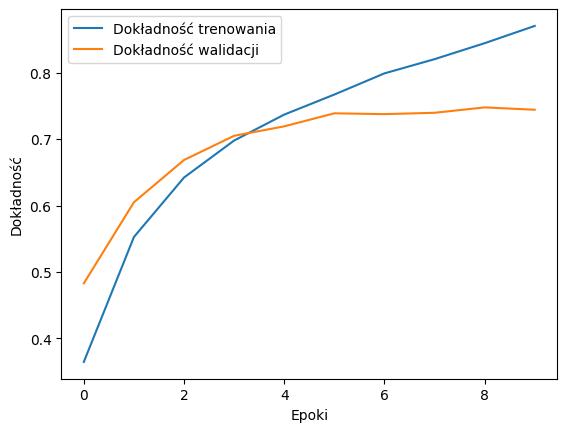

In [ ]:
plt.plot(history.history['accuracy'], label = 'Dokładność trenowania')
plt.plot(history.history['val_accuracy'], label = 'Dokładność walidacji')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

Strata

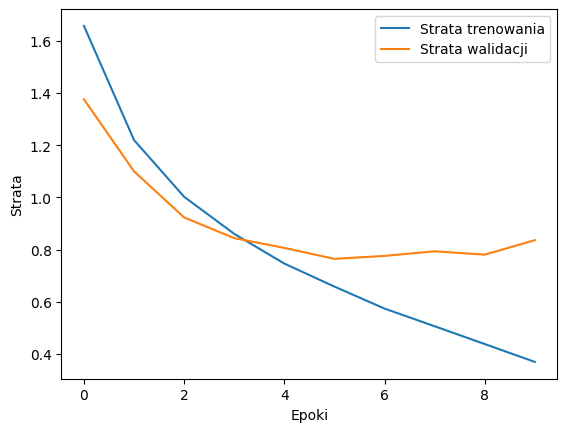

In [ ]:
plt.plot(history.history['loss'], label = 'Strata trenowania')
plt.plot(history.history['val_loss'], label = 'Strata walidacji')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

## Zapisanie modelu

>Nazwa modelu: `cifar10_dokładność-modelu`   
Przykład: `cifar10_99` dla modelu o dokładności 99%

In [ ]:
model.save('Models/cifar10_73.keras')

# ❗ Wczytanie modelu
Podanie ścieżki do modelu, wytrenowane modele znadują się w folderze **Models**

In [ ]:
from tensorflow.keras.models import load_model

Utworzenie modelu

In [ ]:
model = model = models.Sequential()

1. Wczytanie modelu `cifar10_73` - Warstwy konwolucyjne: [64, 128, 256, 256] dla zbioru danych **CIFAR-10**

In [ ]:
model = load_model('Models/cifar10_73.keras') # Wczytanie modelu trenowanego na zbiorze cifar-10 z dokładnością 73%

2. Wczytanie modelu `cifar100_37` - Warstwy konwolucyjne: [64, 128] dla zbioru danych **CIFAR-100**

In [ ]:
model = load_model('Models/cifar100_37.keras') # Wczytanie modelu trenowanego na zbiorze cifar-100 z dokładnością 37%

# Testowanie modelu

## Testy na własnych obrazach

Etykiety dla **CIFAR-10**

In [ ]:
cifar10_labels = [
    'samolot', 'samochód', 'ptak', 'kot', 'jeleń', 'pies', 'żółw', 'jeż',
    'kon', 'statek'
]

Etykiety dla **CIFAR-100**

In [ ]:
cifar100_labels = [
    'jabłko', 'ryba akwariowa', 'niemowlę', 'niedźwiedź', 'bóbr', 'łóżko', 'pszczoła', 'żuk',
    'rower', 'butelka', 'miska', 'chłopiec', 'most', 'autobus', 'motyl', 'wielbłąd',
    'puszka', 'zamek', 'gąsienica', 'bydło', 'krzesło', 'szympans', 'zegar',
    'chmura', 'karaluch', 'kanapa', 'krab', 'krokodyl', 'filiżanka', 'dinozaur',
    'delfin', 'słoń', 'płastuga', 'las', 'lis', 'dziewczynka', 'chomik',
    'dom', 'kangur', 'klawiatura', 'lampa', 'kosiarka do trawy', 'lampart', 'lew',
    'jaszczurka', 'homar', 'mężczyzna', 'klon', 'motocykl', 'góra', 'mysz',
    'grzyb', 'dąb', 'pomarańcza', 'orchidea', 'wydra', 'palma', 'gruszka',
    'pickup', 'sosna', 'równina', 'talerz', 'mak', 'jeżozwierz',
    'opos', 'królik', 'szop pracz', 'płaszczka', 'droga', 'rakieta', 'róża',
    'morze', 'foka', 'rekin', 'ryjówka', 'skunks', 'drapacz chmur', 'ślimak', 'wąż',
    'pająk', 'wiewiórka', 'tramwaj', 'słonecznik', 'papryka', 'stół',
    'czołg', 'telefon', 'telewizor', 'tygrys', 'ciągnik', 'pociąg', 'pstrąg',
    'tulipan', 'żółw', 'szafa', 'wieloryb', 'wierzba', 'wilk', 'kobieta',
    'robak'
]


## Klasyfikacja obrazka

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

## Wczytanie obrazka
Podanie ścieżki do obrazka, obrazki testowe znadują się w folderze **Images**

In [ ]:
img_path = 'Images/deer.jpg'

Przetworzenie obrazka na tablice Numpy

In [ ]:
# Przetworzenie na 32x32 piksele - rozmiar na którym był uczony model
def prepare_image(img_path):
    img_ = image.load_img(img_path, target_size=(32, 32))

    img_array = image.img_to_array(img_)

    img_array = img_array / 255.0

    img_array = np.expand_dims(img_array, axis = 0)

    return img_array

# Przetworzenie na 512x512 piksele - w celu prezentacji permutacji na lepszej jakości obrazie
def prepare_image_512(img_path):
    img_ = image.load_img(img_path, target_size=(512, 512))

    img_array = image.img_to_array(img_)

    img_array = img_array / 255.0

    img_array = np.expand_dims(img_array, axis = 0)

    return img_array


Rozmiar obrazu po klasyfikacji: (1, 32, 32, 3)


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

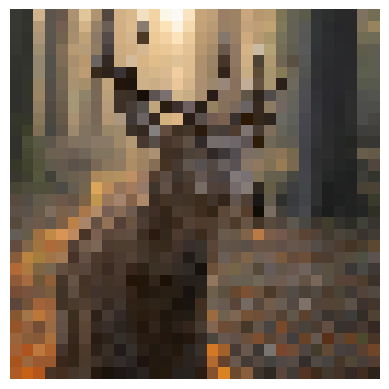

In [ ]:
img_array = prepare_image(img_path)

print(f"Rozmiar obrazu po klasyfikacji: {img_array.shape}")
plt.imshow(img_array[0])
plt.axis('off')

Klasyfikacja obrazka

In [ ]:
# Podstawowa klasyfikacja obrazka
def classify_image(img_array):
    predictions = model.predict(img_array)

    predicted_class = np.argmax(predictions)

    print(f'\nTo prawdopodobnie {cifar10_labels[predicted_class]}')

    plt.imshow(img_array[0])
    plt.axis('off')

# Klasyfikacja obrazka z detalami, jakie predykcje dla każdej klasy
def classify_image_details(img_array):
    predictions = model.predict(img_array)

    print("\nWynik prawdopodobieństw dla każdej z klas:")
    for i, prob in enumerate(predictions[0]):
        print(f'{i}: {cifar10_labels[i]}: {prob:.4f}')

    predicted_class = np.argmax(predictions)

    print(f'\nNumer przewidzianej klasy: {predicted_class}')
    print(f'\nZ prawdopodobieństwem: {predictions[0][predicted_class] * 100:.2f}%')
    print(f'\nTo prawdopodobnie {cifar10_labels[predicted_class]}')

# Klasyfikacja obrazka zwracająca etykiete i predykcję w procentach
def classify_image_text(img_array):
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    return cifar10_labels[predicted_class], f"{predictions[0][predicted_class] * 100:.2f}%"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step

To prawdopodobnie jeleń


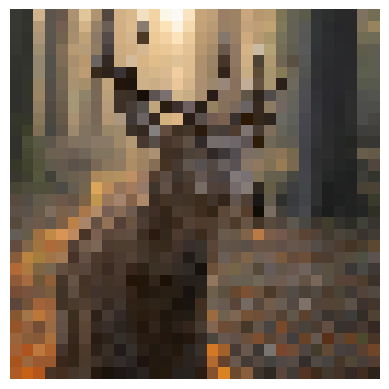

In [ ]:
classify_image(img_array)

In [ ]:
classify_image_details(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Wynik prawdopodobieństw dla każdej z klas:
0: samolot: 0.0001
1: samochód: 0.0000
2: ptak: 0.0141
3: kot: 0.0077
4: jeleń: 0.9634
5: pies: 0.0074
6: żółw: 0.0013
7: jeż: 0.0061
8: kon: 0.0000
9: statek: 0.0000

Numer przewidzianej klasy: 4

Z prawdopodobieństwem: 96.34%

To prawdopodobnie jeleń


In [ ]:
classify_image_text(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


('jeleń', '96.34%')

# Przeprowadzenie ataku adwersarialnego

## Atak Pierwszy

#**Fast Gradient Sign Method (FGSM)** 🔹 Szybki i prosty atak oparty na gradiencie.
>Głównym celem tego typu ataku jest wprowadzenie **niewielkich**, ale celowych zakłóceń do danych wejściowych, tak aby oszukać model i spowodować błędną klasyfikację mimo, że zmodyfikowane dane wyglądają niemal identycznie dla człowieka jak oryginał.

>FGSM wykorzystuje gradient funkcji straty względem danych wejściowych, aby dowiedzieć się, w którą stronę należy przesunąć piksele, by zwiększyć błąd predykcji modelu.


In [ ]:
import tensorflow as tf
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

### Przykład pierwszy
Przeprowadzenie ataku FGSM (Fast Gradient Sign Method)

>Obraz 32x32 piksele, ponieważ takie obrazy zawiera zbiór danych **CIFAR-10**, na którym był trenowany model

ATAK

> Wartość **epsilon** (`eps`), odpowiada za moc ataku

W ramach testów można sprawdzić różne wartości epsilon

In [ ]:
adv_image = fast_gradient_method(model, img_array, eps=0.02, norm=np.inf, clip_min=0.0, clip_max=1.0)

Reprezentacja wyników

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


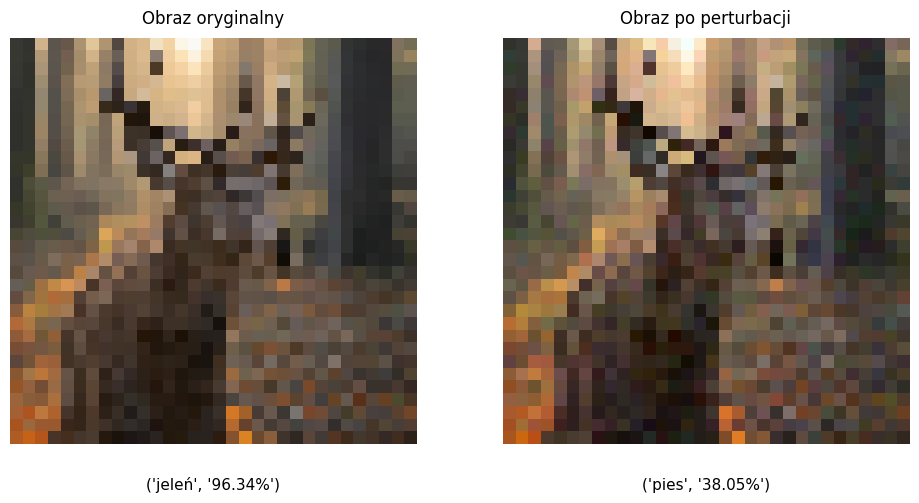

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Jeden rząd, dwa obrazy

# Obraz oryginalny
axs[0].imshow(img_array[0])
axs[0].axis('off')
axs[0].set_title("Obraz oryginalny", pad=10)
axs[0].text(0.5, -0.1, classify_image_text(img_array), transform=axs[0].transAxes,
            ha='center', va='center', fontsize=11)

# Obraz po perturbacji
axs[1].imshow(adv_image[0])
axs[1].axis('off')
axs[1].set_title("Obraz po perturbacji", pad=10)
axs[1].text(0.5, -0.1, classify_image_text(adv_image), transform=axs[1].transAxes,
            ha='center', va='center', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Podsumowanie:
- Dla eps = 0.02 obraz **jelenia** klasyfikowany jako **pies**

> Perturbacja przeprowadzona na obrazie 32x32 piksele przy ustawionej wartości epsilon na **0.02**, wprowadza skutecznie model w błąd.


In [ ]:
classify_image_details(adv_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

Wynik prawdopodobieństw dla każdej z klas:
0: samolot: 0.0001
1: samochód: 0.0001
2: ptak: 0.0731
3: kot: 0.2104
4: jeleń: 0.1973
5: pies: 0.3805
6: żółw: 0.0247
7: jeż: 0.1125
8: kon: 0.0002
9: statek: 0.0011

Numer przewidzianej klasy: 5

Z prawdopodobieństwem: 38.05%

To prawdopodobnie pies


### Przykład drugi
Przeprowadzenie ataku FGSM (Fast Gradient Sign Method) na wyraźniejszym obrazie
>Obraz wyraźny 512x512 pikseli w celu pokazania perturbacji, następnie przeskalowany do 32x32 piksele przed klasyfikacją

Rozmiar obrazu po klasyfikacji: (1, 512, 512, 3)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

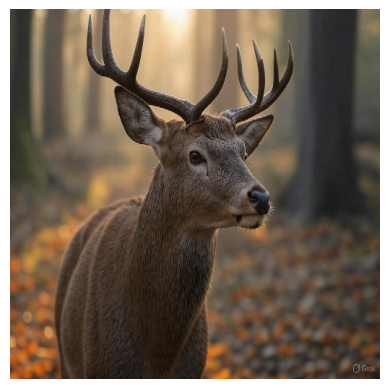

In [ ]:
img_array_2 = prepare_image_512(img_path)

print(f"Rozmiar obrazu po klasyfikacji: {img_array_2.shape}")
plt.imshow(img_array_2[0])
plt.axis('off')

ATAK

> Wartość **epsilon** (`eps`), odpowiada za moc ataku

W ramach testów można sprawdzić różne wartości epsilon

In [ ]:
adv_image_2 = fast_gradient_method(model, img_array_2, eps=0.8, norm=np.inf, clip_min=0.0, clip_max=1.0)

Reprezentacja wyników

In [ ]:
from PIL import Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


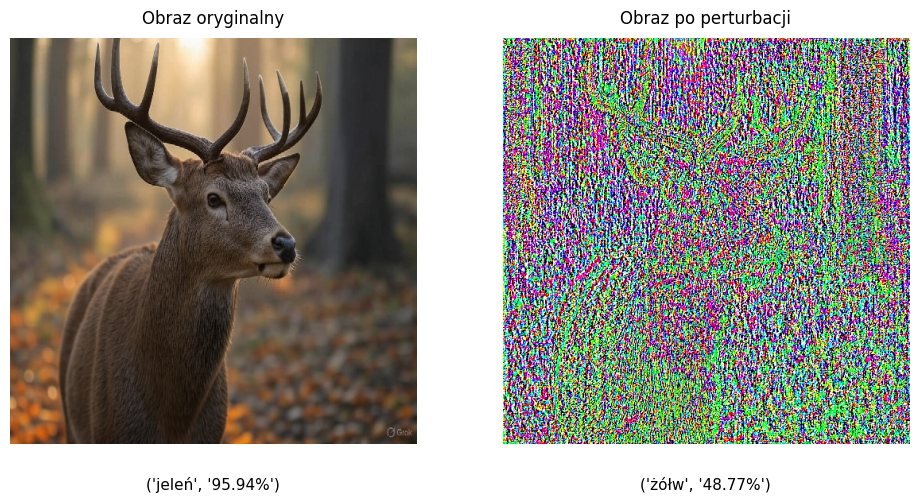

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Jeden rząd, dwa obrazy

# Obraz oryginalny
axs[0].imshow(img_array_2[0])
axs[0].axis('off')
axs[0].set_title("Obraz oryginalny", pad=10)

# Przeskalowanie obrazu z 512x512 do 32x32 w celu dopasowania do obrazów na których trenowany był model
# Usunięcia wymiaru batchowego
img_512 = img_array_2[0]  # nowy kształt: (512, 512, 3)

# Przeskalowanie do 32x32
img_pil = Image.fromarray((img_512 * 255).astype(np.uint8))  # konwersja do uint8
img_resized = img_pil.resize((32, 32))

# Zamiana z powrotem na NumPy i normalizacja
img_array_32 = np.array(img_resized) / 255.0

# Dodanie z powrotem wymiaru batchowego
img_array_32 = np.expand_dims(img_array_32, axis=0)


axs[0].text(0.5, -0.1, classify_image_text(img_array_32), transform=axs[0].transAxes,
            ha='center', va='center', fontsize=11)


# Obraz po perturbacji
axs[1].imshow(adv_image_2[0])
axs[1].axis('off')
axs[1].set_title("Obraz po perturbacji", pad=10)

# Przeskalowanie obrazu z 512x512 do 32x32 w celu dopasowania do obrazów na których trenowany był model
# Usunięcia wymiaru batchowego
adv_512 = adv_image_2[0]  # nowy kształt: (512, 512, 3)

# Przeskalowanie do 32x32
adv_pil = Image.fromarray((adv_512.numpy() * 255).astype(np.uint8))  # konwersja do uint8
adv_resized = adv_pil.resize((32, 32))

# Zamiana z powrotem na NumPy i normalizacja
adv_image_32 = np.array(adv_resized) / 255.0

# Dodanie z powrotem wymiaru batchowego
adv_image_32 = np.expand_dims(adv_image_32, axis=0)


axs[1].text(0.5, -0.1, classify_image_text(adv_image_32), transform=axs[1].transAxes,
            ha='center', va='center', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Podsumowanie:

- Dla eps = 0.02 obraz **jelenia** klasyfikowany **poprawnie**
- Dla eps = 0.7 obraz **jelenia** klasyfikowany **poprawnie**
- Dla eps = 0.8 obraz **jelenia** klasyfikowany jako obraz **żółwia**

> Gdy obraz jest 512x512 pikseli, a następnie skalowany do 32x32 piksele, potrzeba perturbacji z epsilon na poziomie 0.8, aby zmylić model.

> Taka perturbacja jest bardzo mocna i znacząco zmienia wygląd obrazu także dla człowieka.

In [ ]:
classify_image_details(adv_image_2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step

Wynik prawdopodobieństw dla każdej z klas:
0: samolot: 0.0000
1: samochód: 0.0000
2: ptak: 0.1229
3: kot: 0.0010
4: jeleń: 0.2033
5: pies: 0.0000
6: żółw: 0.6728
7: jeż: 0.0000
8: kon: 0.0000
9: statek: 0.0000

Numer przewidzianej klasy: 6

Z prawdopodobieństwem: 67.28%

To prawdopodobnie żółw


### Przykład trzeci
Przeprowadzenie ataku FGSM (Fast Gradient Sign Method) na wyraźniejszym obrazie - **podejście drugie**
>Obraz wyraźny 512x512 pikseli, przeprowadzenie ataku po przeskalowaniu obrazu na 32x32 piksele, przed klasyfikacją

Rozmiar obrazu po klasyfikacji: (1, 512, 512, 3)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

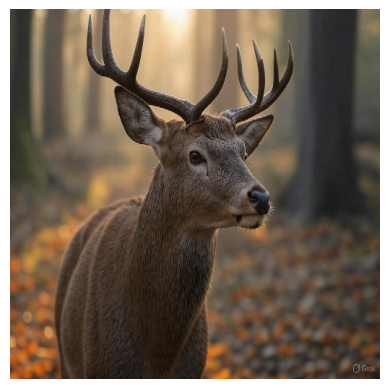

In [ ]:
img_array_2 = prepare_image_512(img_path)

print(f"Rozmiar obrazu po klasyfikacji: {img_array_2.shape}")
plt.imshow(img_array_2[0])
plt.axis('off')

Reprezentacja wyników

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


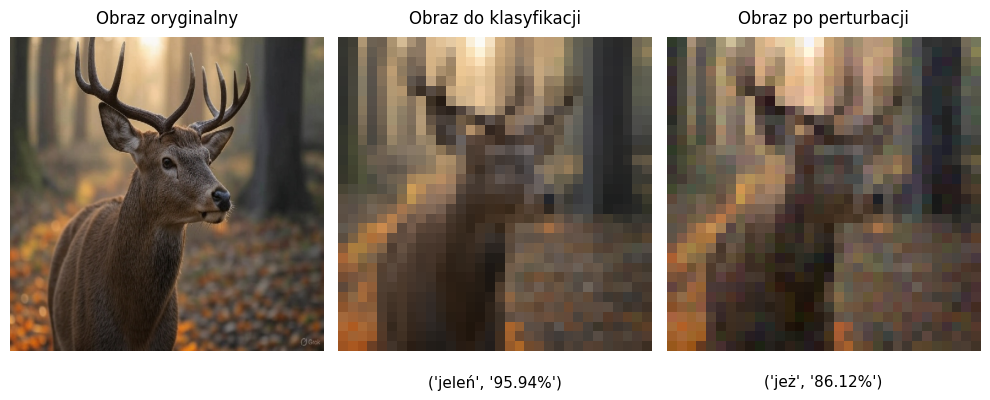

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))  # Jeden rząd, dwa obrazy

# Obraz oryginalny
axs[0].imshow(img_array_2[0])
axs[0].axis('off')
axs[0].set_title("Obraz oryginalny", pad=10)

# Przeskalowanie obrazu z 512x512 do 32x32 w celu dopasowania do obrazów na których trenowany był model
# Usunięcia wymiaru batchowego
img_512 = img_array_2[0]  # nowy kształt: (512, 512, 3)

# Przeskalowanie do 32x32
img_pil = Image.fromarray((img_512 * 255).astype(np.uint8))  # konwersja do uint8
img_resized = img_pil.resize((32, 32))

# Zamiana z powrotem na NumPy i normalizacja
img_array_32 = np.array(img_resized) / 255.0

# Dodanie z powrotem wymiaru batchowego
img_array_32 = np.expand_dims(img_array_32, axis=0)


axs[0].text(0.5, -0.1, '', transform=axs[0].transAxes,
            ha='center', va='center', fontsize=11)


# Obraz oryginalny do klasyfikacji
axs[1].imshow(img_array_32[0])
axs[1].axis('off')
axs[1].set_title("Obraz do klasyfikacji", pad=10)
axs[1].text(0.5, -0.1, classify_image_text(img_array_32), transform=axs[1].transAxes,
            ha='center', va='center', fontsize=11)


# Przeskalowanie obrazu z 512x512 do 32x32 w celu dopasowania do obrazów na których trenowany był model
# Usunięcia wymiaru batchowego
adv_512 = img_array_2[0]  # nowy kształt: (512, 512, 3)

# Przeskalowanie do 32x32
adv_pil = Image.fromarray((adv_512 * 255).astype(np.uint8))  # konwersja do uint8
adv_resized = adv_pil.resize((32, 32))

# Zamiana z powrotem na NumPy i normalizacja
adv_array_32 = np.array(adv_resized) / 255.0

# Dodanie z powrotem wymiaru batchowego
adv_array_32 = np.expand_dims(adv_array_32, axis=0)

'''
ATAK

> Wartość **epsilon** (`eps`), odpowiada za moc ataku

W ramach testów można sprawdzić różne wartości epsilon
'''
# Przeprowadzenie ataku
adv_image_32_atk = fast_gradient_method(model, adv_array_32, eps=0.02, norm=np.inf, clip_min=0.0, clip_max=1.0)

# Obraz po perturbacji
axs[2].imshow(adv_image_32_atk[0])
axs[2].axis('off')
axs[2].set_title("Obraz po perturbacji", pad=10)
axs[2].text(0.5, -0.1, classify_image_text(adv_image_32_atk), transform=axs[2].transAxes,
            ha='center', va='center', fontsize=11)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Podsumowanie:

- Dla eps = 0.02 obraz **jelenia** klasyfikowany jako **jeż**

> Perturbacja przeprowadzona po przeskalowaniu obrazu przy ustawionej wartości epsilon na **0.02**, wprowadza skutecznie model w błąd.

In [ ]:
classify_image_details(adv_image_32_atk)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step

Wynik prawdopodobieństw dla każdej z klas:
0: samolot: 0.0000
1: samochód: 0.0000
2: ptak: 0.0014
3: kot: 0.0019
4: jeleń: 0.0494
5: pies: 0.0860
6: żółw: 0.0001
7: jeż: 0.8612
8: kon: 0.0000
9: statek: 0.0000

Numer przewidzianej klasy: 7

Z prawdopodobieństwem: 86.12%

To prawdopodobnie jeż
